In [1]:
# test_find_dune_toe
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from pybeach.beach import Profile
from pybeach.support import data_support as ds
from pybeach.support import classifier_support as cs

In [2]:
def find_toe(dist,z,s=0.2,zz=2.4,izero='offshore',iplot=True):
    """
    Find the toe of the dune using three algorithms:
      * Most offshore occurrence of z>=ztoe
      * Maximum inflection point
      * Longest chord from reference slope to elevations
      
    Input:
      dist = distance along profile (m; no origin necessary)
      z = elevation profile (m)
      s = slope of reference line (m/m)
      zz = elevation of fixed dune toe (m)
      izero = 'offshore' or 'onshore' - origin of profile: offshore indicates profile distances increase shoreward
      
    Returns:
      izz - index of toe using fixed elevation method (same as input value; m)
      izc - index of toe using chord method (distance from reference line) (m)
      izip - index of toe using inflection point (m)
      zz - elevation of toe using fixed elevation method (same as input value; m)
      ztoe - elevation of toe using distance from reference line (m)
      zipt - elevation of toe using inflection point (m)
      
    Note: assumes maximum z == foredune crest. If not, then pass a shortened transect that only include dune and beach
    """
    # initialize return values
    izz = np.nan
    izc = np.nan
    izp = np.nan
    zz = zz
    ztoe = np.nan
    zipt = np.nan
        
    if izero == 'offshore': #transect goes from offshore to onshore
        # highest point for offset starting point in offshore segment
        izmax = np.argmax(z)
        zb = z[izmax:-1]
        db = dist[izmax:-1]-dist[izmax]
        
        # chord method: make a sloping reference line
        zr = z[izmax] - s*db
        # find greatest vertical diff between ref line and topography
        zd = zr-zb
        izc = np.argmax(zd)
        zc = zb[izc]
        
        # inflection point method: find minimum in dz/dx
        dzb = np.array([0])
        dzb = np.append(dzb,np.diff(zb)/np.diff(db))
        # inflection point at (first) minimum dz/dx
        izip = np.argmin(dzb)
        zipt = zb[izip]

        # fixed elevation method: find values greater than zz
        iztall = np.squeeze(np.where(zb>=zz))
        # chose last one headed offshore
        izz = iztall[-1]
        
        # add back in offset
        izip = izip+izmax
        izc = izc+izmax
        izz = izz+izmax
    
    else: # transect from onshore to offshore
        # highest point for starting point in offshore segment
        izmax = np.argmax(z)
        zb = z[0:izmax]
        db = dist[0:izmax]
        
        # chord method: make a sloping reference line
        zr = z[izmax] - s*np.flip(db)
        # find greatest vertical diff between ref line and topography
        zd = zr-zb
        izc = np.argmax(zd)
        zc = zb[izc]
        
        # inflection point method: find minimum in dz/dx
        dzb = np.array([0])
        dzb = -np.append(dzb,np.diff(zb)/np.diff(db))
        # inflection point at (first) minimum dz/dx
        izip = np.argmin(dzb)
        zipt = zb[izip]

        # fixed elevation method: find values greater than zz
        iztall = np.squeeze(np.where(zb>=zz))
        # chose last one headed offshore
        izz = iztall[0]
    
    return izz,izc,izip,zz,zc,zipt

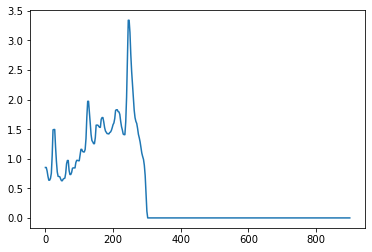

In [48]:
# Load some test data of 200 profiles
with open('C:/crs/src/pybeach/example/test_profiles.pkl', 'rb') as f:
    data = pickle.load(f)
x, za, toe = data['x'], data['z'], data['toe']
i=0
z=za[i]
plt.plot(x,z)
zz=1.8

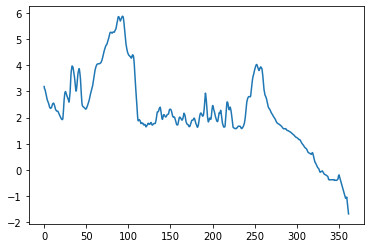

In [53]:
# Load one of my profiles
z=za[i,:]

df = pd.read_csv('test_profile9.csv')
x = df['Distance (Total)'].values
z = df['Elevation'].values
plt.plot(x,z)
zz=2.4

753 2.4
315 1.916
305 3.618


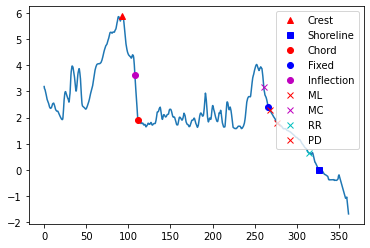

In [54]:
izz,iztoe,izip,zz,ztoe,zipt = find_toe(x,z,zz=zz,s=0.2,izero='offshore')
print(izz,zz)
print(iztoe,ztoe)
print(izip,zipt)

# Instantiate Profile class
p = Profile(x, z)
# Make predictions of dune toe
window_size=21
threshold = .97
water_level = 0.
toe_ml, prob_ml = p.predict_dunetoe_ml('barrier_island_clf', dune_crest='rr', window_size=window_size, threshold=threshold)
toe_mc = p.predict_dunetoe_mc(dune_crest='rr', window_size=window_size, threshold=threshold)
toe_rr = p.predict_dunetoe_rr(dune_crest='rr', window_size=window_size, threshold=threshold, toe_threshold=0.2, water_level=water_level,verbose=False)
toe_pd = p.predict_dunetoe_pd(dune_crest='rr', window_size=window_size, threshold=threshold, water_level=water_level)
# Predict dune crest
crest = p.predict_dunecrest()
# Predict shoreline
shoreline = p.predict_shoreline()

fig, ax = plt.subplots(1,1)
plt.plot(x,z)
plt.plot(x[crest],z[crest],'^r',label='Crest')
plt.plot(x[shoreline],z[shoreline],'sb',label='Shoreline')
           
plt.plot(x[iztoe],z[iztoe],'or',label='Chord')
plt.plot(x[izz],z[izz],'ob',label='Fixed')
plt.plot(x[izip],z[izip],'om',label='Inflection')
plt.plot(x[toe_ml],z[toe_ml],'xr',label='ML')
plt.plot(x[toe_mc],z[toe_mc],'xm',label='MC')
plt.plot(x[toe_rr],z[toe_rr],'xc',label='RR')
plt.plot(x[toe_pd],z[toe_pd],'xr',label='PD')
_=plt.legend()

z: (200, 361)
toe: (200,)
(200, 1)


(array([ 3.,  9., 27., 23., 34., 42., 40., 19.,  2.,  1.]),
 array([0.69000739, 0.89319418, 1.09638097, 1.29956776, 1.50275454,
        1.70594133, 1.90912812, 2.1123149 , 2.31550169, 2.51868848,
        2.72187527]),
 <BarContainer object of 10 artists>)

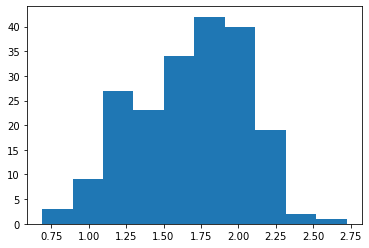

In [5]:
print('z:',np.shape(z))
print('toe:',np.shape(toe))
th = np.zeros((200,1))
print(np.shape(th))
for k, iz in enumerate(toe):
    th[k]=z[k,iz]

plt.hist(th)

In [6]:


# Instantiate Profile class
p = Profile(x, z[i])
# Make predictions of dune toe
toe_ml, prob_ml = p.predict_dunetoe_ml('barrier_island_clf', dune_crest='rr', window_size=101, threshold=0.97)
toe_mc = p.predict_dunetoe_mc(dune_crest='rr', window_size=101, threshold=0.97)
toe_rr = p.predict_dunetoe_rr(dune_crest='rr', window_size=101, threshold=0.97, toe_threshold=0.2, verbose=False)
toe_pd = p.predict_dunetoe_pd(dune_crest='rr', window_size=101, threshold=0.97)
# Predict dune crest
crest = p.predict_dunecrest()
# Predict shoreline
shoreline = p.predict_shoreline()

In [8]:
print(toe_mc)

[128]
